In [287]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [288]:
from __future__ import division, unicode_literals, print_function  # for compatibility with Python 2 and 3

import matplotlib as mpl 
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation

%matplotlib inline

# Optionally, tweak styles.
mpl.rc('figure',  figsize=(10, 5))
import numpy as np
import pandas as pd
from pandas import DataFrame, Series  # for convenience
import os
import seaborn as sns
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')
import pims
import pySPM as spm 
import trackpy as tp
import glob
from sxmreader import SXMReader

In [41]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [322]:
molecule_size = 7
min_mass = 2
max_mass = 100
min_size = 1
max_ecc = 1
separation = 5
search_range = 50
adaptive_stop = 2
f = tp.batch(frames[:], diameter=molecule_size, minmass=min_mass, separation=separation)
#f['angle'] = 0
#f.loc[(f['orientation']>=0) & (f['orientation']<np.pi/2),['angle']]=2*2*np.pi/3
#f.loc[(f['orientation']<0) & (f['orientation']>-np.pi/2),['angle']]=1*2*np.pi/3
#f.loc[f['ecc']<0.2,['angle']]=0

Frame 9: 636 features


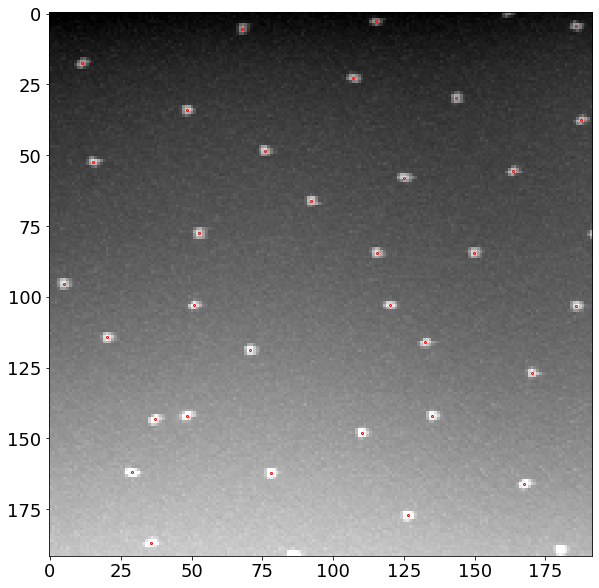

(-0.5, 191.5, 191.5, -0.5)

In [474]:
fig=plt.figure(figsize=(10, 10))
idx = 2
ax = tp.annotate(f[f['frame']==idx], frames[idx], plot_style={'markersize':1})
ax.axis('off')

In [104]:
from collections import namedtuple

In [472]:




#params for e30,31
molecule_size = 13
min_mass = 2
max_mass = 100
min_size = 1
max_ecc = 1
separation = 5
search_range = 50
adaptive_stop = 2

#params
molecule_size = 7
min_mass = 2
max_mass = 100
min_size = 1
max_ecc = 1
separation = 5
search_range = 50
adaptive_stop = 1


#e31/-30Vg
voltage = np.arange(0.6, 3.2, 0.2)
START = 3
base_folder_n = 31

#e30/30Vg
voltage = np.arange(0.6, 3.4, 0.2)
START = 814 
base_folder_n = 30

"""
#e8/60Vg
voltage = np.arange(2.2, 4.3, 0.3)
START = 533
base_folder_n = 8

#e8/-15Vg sets= [range(657,667), range(667,676), range(611,621), range(621,631), range(631,641), range(641,651), range(651,657)]
voltage = np.arange(0.8, 1.5, 0.1)

#e8/-15Vg sets= [range(725,732), range(732,739), range(686,696), range(696,706), range(706,716), range(716,725)]
voltage = np.arange(4.8, 5.4, 0.1)


#e10/-20Vg
voltage = [1.6, 1.8, 1.9, 2, 2.1, 2.2, 2.3, 2.4, 2.5]
sets = [range(833,863), range(863,893), range(893,923), range(668,698),range(698,728),range(728,758),range(758,788),range(788,818),range(818,833)]
base_folder_n = 10


#e12/ 10Vg no good
voltage = np.arange(4.4, 5.8, 0.2)
START = 497
base_folder_n = 12
"""

#e14/-20Vg
voltage = np.arange(1.2, 1.45, 0.05)
START = 768
base_folder_n = 15

SIZE = 5
sets = [range(START + SIZE * i, START + SIZE * (i + 1)) for i in range(len(voltage))]
#sets= [range(725,732), range(732,739), range(686,696), range(696,706), range(706,716), range(716,725), range(676, 686)]
n_range = [i for i in sets]
N = [len(i) for i in sets]

SXM_PATH = [["electromigration_{0:1}/Image_{1:03}.sxm".format(base_folder_n,i) for i in n_range[j]] for j in range(len(n_range))]

total_molecules=[]
rotation_frac = []
total_moved = []
total_rotated = []
drifts = []
hops = []
D_constants = []
NM_PER_PIXEL = frames.meters_per_pixel * 1e9 

for i, path in enumerate(SXM_PATH):
    frames = SXMReader(path)
    f = tp.batch(frames[:], diameter=molecule_size, minmass=min_mass, separation=separation)
    t = tp.link(f, search_range=search_range, adaptive_stop=adaptive_stop, adaptive_step=0.99)
    
    # Filter out noise particles
    t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
    t2 = tp.filter_stubs(t, 1)
          
    # Compare the number of particles in the unfiltered and filtered data.
    print('Before:', t['particle'].nunique())
    print('After:', t2['particle'].nunique())

    # Compute and subtract drift
    d = tp.compute_drift(t2)
    drifts.append(d)
    d.loc[0] = [0, 0]
    
    # Compute all displacements
    t3 = t2.copy()
    #t3 = tp.subtract_drift(t2.copy(), d)
    displacements = tp.relate_frames(t3, 0, 1) * NM_PER_PIXEL
    for i in range(SIZE):
        displacements = displacements.append(tp.relate_frames(t3, i, i + 1) * NM_PER_PIXEL, ignore_index=True)
    displacements = displacements.dropna()
    displacements["rotated"] = (displacements.angle!=displacements.angle_b).astype("int")
    D_constants.append((displacements.dx.var() + displacements.dy.var()) / 4) # r^2 = x^2 + y^2 = 2Dt + 2Dt
    hops.append(displacements)

    # Compute number of rotated molecules
    rotated = displacements.rotated.sum()
    moved = len( displacements[displacements.dr > 0.1].index)
    total_molecules.append(len(displacements.index))
    total_moved.append(moved)
    total_rotated.append(rotated)
    
rotation_frac = np.array(total_rotated)/total_moved

Frame 4: 30 trajectories present.
Before: 34
After: 34


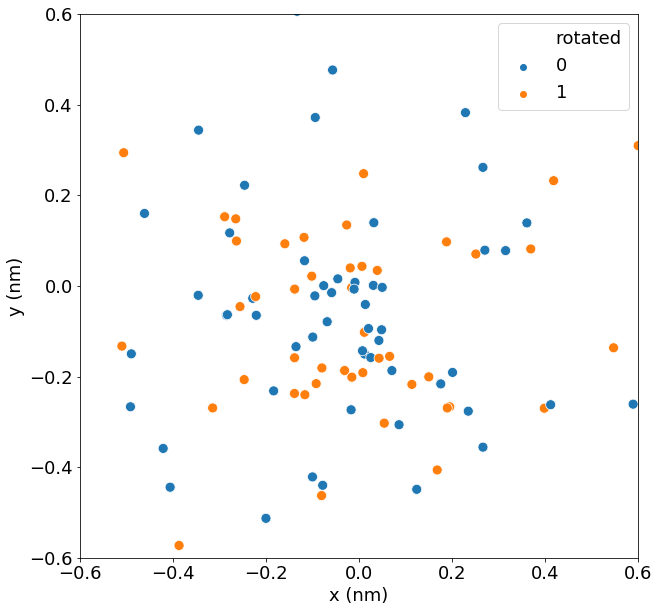

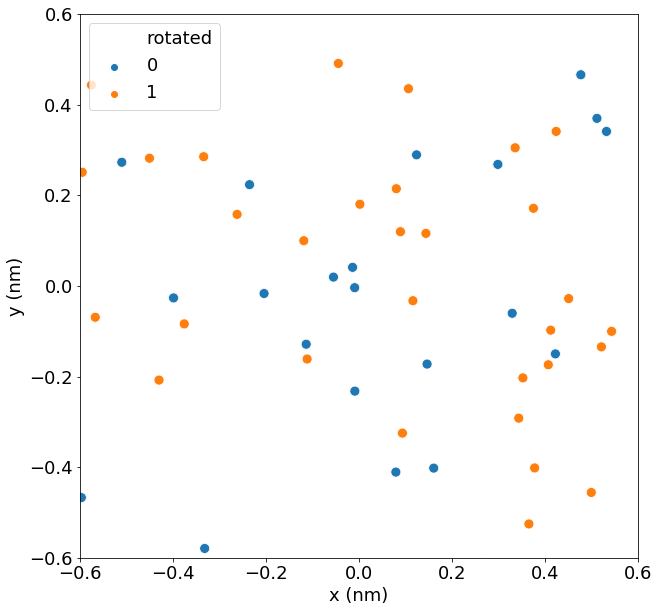

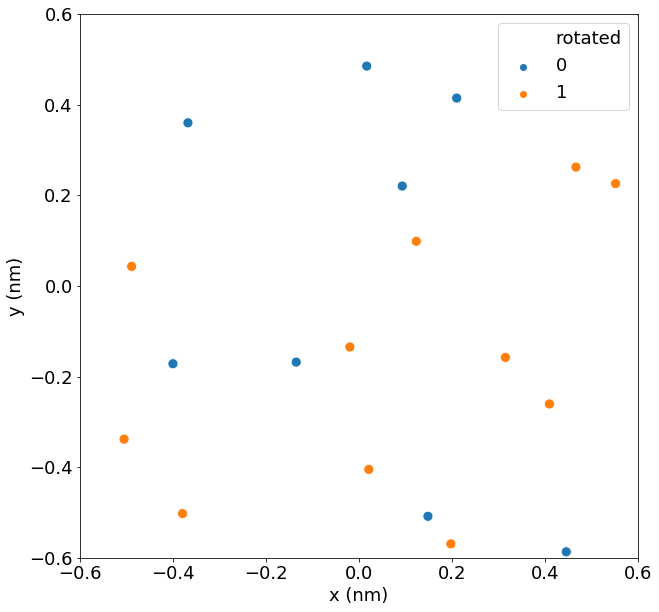

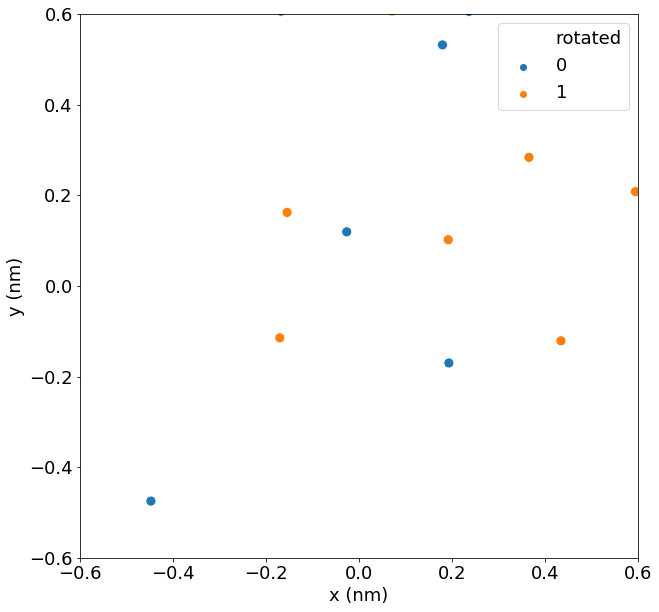

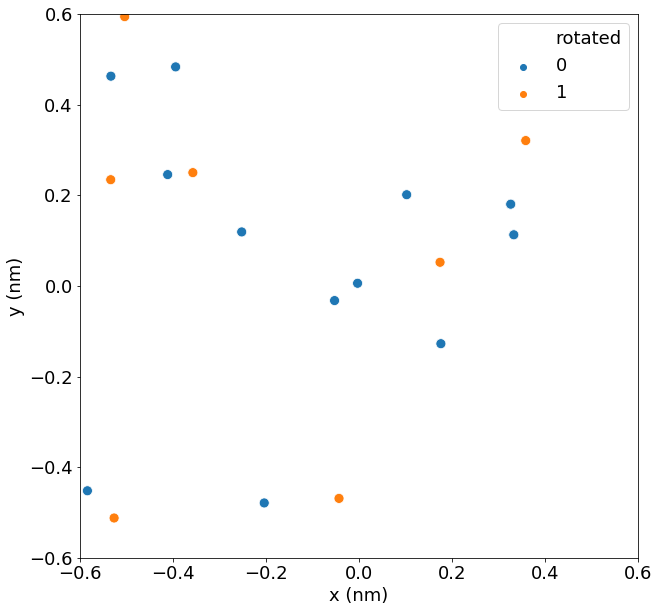

In [473]:
for i in range(len(hops)):
    plt.figure(figsize=(10, 10))
    sns.scatterplot(x='dx', y='dy', data=hops[i], hue="rotated", s=100)
    plt.xlabel("x (nm)")
    plt.ylabel("y (nm)")
    plt.xlim(-0.6, 0.6)
    plt.ylim(-0.6, 0.6)

In [304]:
rotation_frac1=rotation_frac

In [305]:
voltage1=voltage

In [168]:
voltage1=np.arange(0.6,3.4,0.2)

In [184]:
np.sqrt(np.array(rotation_frac))*10

array([ 7.12879177,  6.66666667,  6.29465182,  6.58758123,  6.43650304,
        6.63324958,  7.43907291,  8.77058019,  8.37808497, 13.45185418,
        7.63762616,  9.48683298, 10.39540842])

In [419]:
voltage = np.arange(4.8,5.35,0.10)

In [445]:
total_molecules

[153, 131, 154, 132, 149, 0, 108, 137, 147]

In [446]:
total_rotated

[103, 92, 101, 34, 45, 0, 72, 96, 96]

In [447]:
total_moved

[148, 129, 145, 122, 138, 0, 103, 134, 142]

In [361]:
rotation_frac

array([0.        , 0.16176471, 0.0273224 , 0.04326923, 0.09796673,
       0.16946309, 0.38041734, 0.03007519, 0.08169935, 0.11278195])

In [283]:
rotation_frac1 = rotation_frac

Text(0, 0.5, '% of molecules')

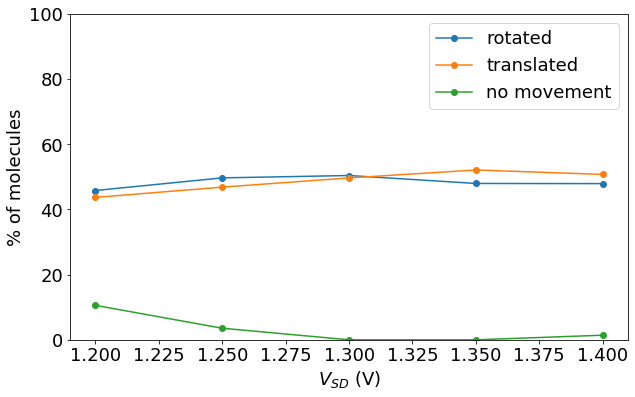

In [475]:
plt.figure(figsize=(10,6))
plt.rcParams.update({'font.size': 18})
plt.plot(voltage,np.array(total_rotated)/total_molecules*100,'o-',label='rotated')
plt.plot(voltage,(np.array(total_moved)-np.array(total_rotated))/total_molecules*100,'o-',label='translated')
plt.plot(voltage,(np.array(total_molecules)-np.array(total_moved))/total_molecules*100,'o-',label='no movement')
plt.legend()
#plt.xlim([0.5,2.0])
plt.ylim([0, 100])
plt.xlabel('$V_{SD}$ (V)')
plt.ylabel('% of molecules')


In [91]:
rotated = []
for i in range(len(frames)-1):
    a = t2[t2.frame == i]
    b = t2[t2.frame == i+1]
    pos_columns = ['x','y']
    j = a.set_index('particle')[pos_columns+['angle']].join(b.set_index('particle')[pos_columns+['angle']], rsuffix='_b')
    j["rotated"]=(j.angle!=j.angle_b).astype("int")
    rotated.append(j.rotated.sum())
rotated.average()

In [96]:
np.average(rotated)

3.111111111111111

In [46]:
t2[t2.frame==0]

,y,x,mass,size,ecc,orientation,angle,signal,raw_mass,ep,frame,particle
frame,,,,,,,,,,,,
0,6.653305,144.010549,2.751242,2.435670,0.178028,-1.046859,2.094395,0.102543,-29.232209,-0.137741,0,0
0,243.048270,245.147541,2.124377,2.568373,0.105468,-1.491684,2.094395,0.073521,47.586801,0.174618,0,1
0,235.120923,104.230708,2.432005,2.571182,0.070357,-0.969046,2.094395,0.081260,47.274999,0.176240,0,2
0,223.758621,179.753605,3.085958,2.631137,0.122813,-1.172920,2.094395,0.088999,47.222645,0.176515,0,3
0,221.766428,45.439818,2.973741,2.583542,0.095393,0.085494,0.000000,0.098673,46.590776,0.179907,0,4
0,173.987635,80.100464,3.755388,2.534969,0.167573,1.090302,4.188790,0.119956,39.757366,0.227109,0,5
0,170.201187,27.817152,3.587063,2.559118,0.119946,0.004508,0.000000,0.110282,38.718988,0.236539,0,6
0,167.774845,133.844720,3.737975,2.547377,0.182913,-1.140531,2.094395,0.118021,38.539018,0.238254,0,7
0,183.905938,238.137677,3.681867,2.521271,0.164660,-1.127997,2.094395,0.119956,41.705986,0.211300,0,8


In [47]:
test = pd.DataFrame()
for i in range(len(frames)-1):
    test= test.append(tp.relate_frames(t2,i,i+1))

In [48]:
pd.set_option('display.max_rows', 500)

In [49]:
test2 =test.dropna()

Drawing multicolor lines takes awhile. Come back in a minute.


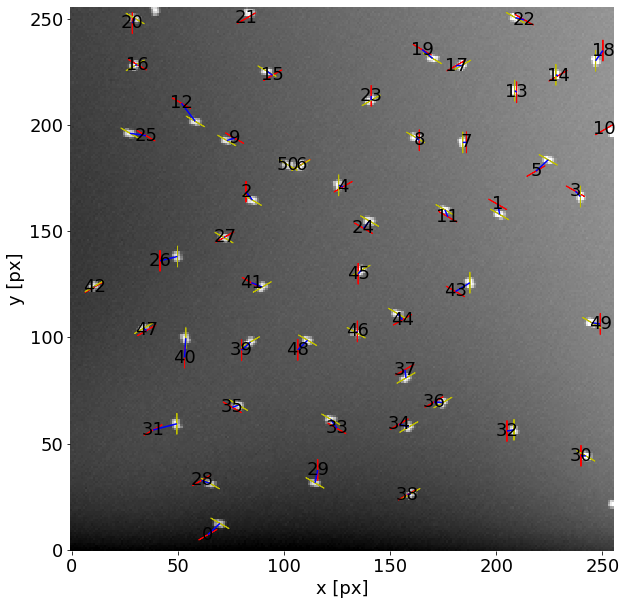

In [467]:
for i in range(1):
    fig=plt.figure(figsize=(10,10))
    ax1=plt.axes(xlim=(0, 256), ylim=(0, 256), frameon=False)
    #ln, = ax1.plot([], [], lw=3)

    tp.plot_traj(t2[(t2['frame']>=i)&(t2['frame']<=i+1)], superimpose=frames[i+1], label=True, colorby='frame', ax=ax1)
    ax1.invert_yaxis()

    R = 10
    tmp = f[f.frame == i]
    for j in range(len(tmp)):
        t = tmp.iloc[j]
        #plt.arrow(t.x, t.y, R * np.sin(t.orientation), R * np.cos(t.orientation), color='y')
        vx=R * np.sin(t.angle)
        vy=R * np.cos(t.angle)
        plt.arrow(t.x-vx/2, t.y-vy/2, vx, vy, color='r')
    tmp = f[f.frame == i+1]
    for j in range(len(tmp)):
        t = tmp.iloc[j]
        #plt.arrow(t.x, t.y, R * np.sin(t.orientation), R * np.cos(t.orientation), color='y')
        vx=R * np.sin(t.angle)
        vy=R * np.cos(t.angle)
        plt.arrow(t.x-vx/2, t.y-vy/2, vx, vy, color='y')
    ax1.axis('square')
    #fig.savefig('test_orientations/{0:03}.png'.format(i))

In [53]:
import imageio

In [54]:
from scipy.ndimage.filters import gaussian_filter1d
a=np.array([1,2,3,4,5]).astype(float)
blurred = gaussian_filter1d(a, sigma=1)

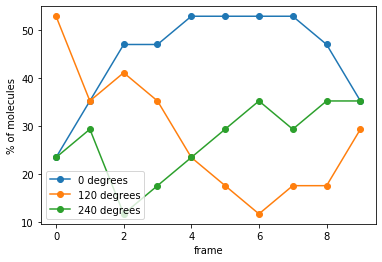

In [55]:
o1=f[f.angle==0].groupby('frame').x.count().to_numpy().astype(float)
o2=f[(f.angle>1) & (f.angle<3)].groupby('frame').x.count().to_numpy().astype(float)
o3=f[(f.angle>3) & (f.angle<6)].groupby('frame').x.count().to_numpy().astype(float)
oo1=gaussian_filter1d(o1, sigma=1)
oo2=gaussian_filter1d(o2, sigma=1)
oo3=gaussian_filter1d(o3, sigma=1)
r1=o1/(o1+o2+o3)*100
r2=o2/(o1+o2+o3)*100
r3=o3/(o1+o2+o3)*100
fig, ax = plt.subplots()
ax.plot(range(len(o1)), r1, 'o-', label='0 degrees')
ax.plot(range(len(o2)), r2, 'o-', label='120 degrees')
ax.plot(range(len(o3)), r3, 'o-', label='240 degrees')
ax.set_xlabel('frame')
ax.set_ylabel('% of molecules')
ax.legend()

In [236]:
test=f.groupby(['frame','angle'])
test[test.angle==0]

KeyError: 'Column not found: False'

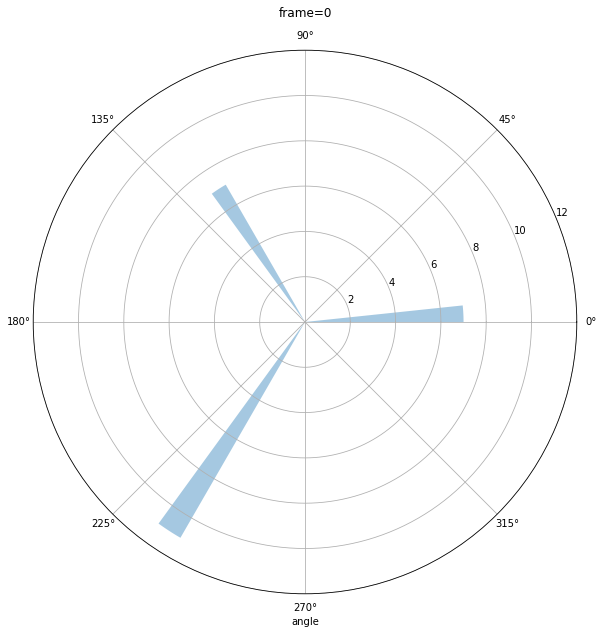

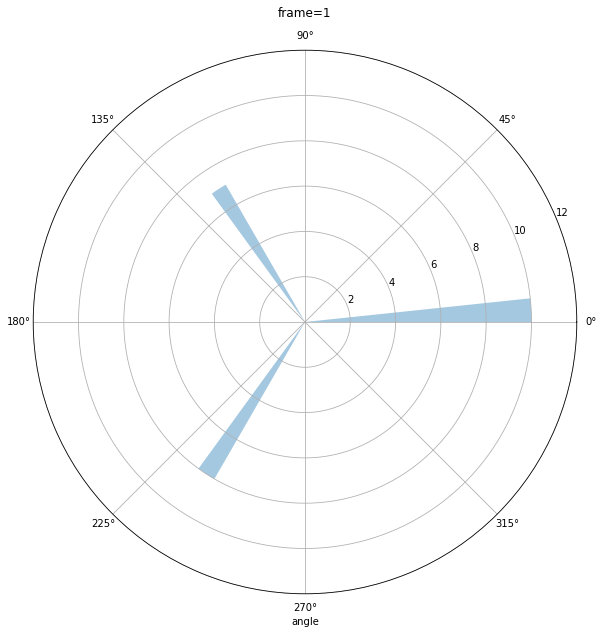

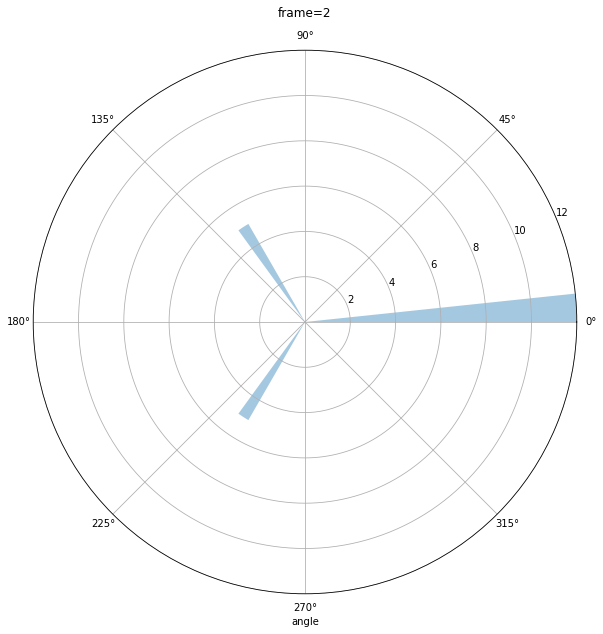

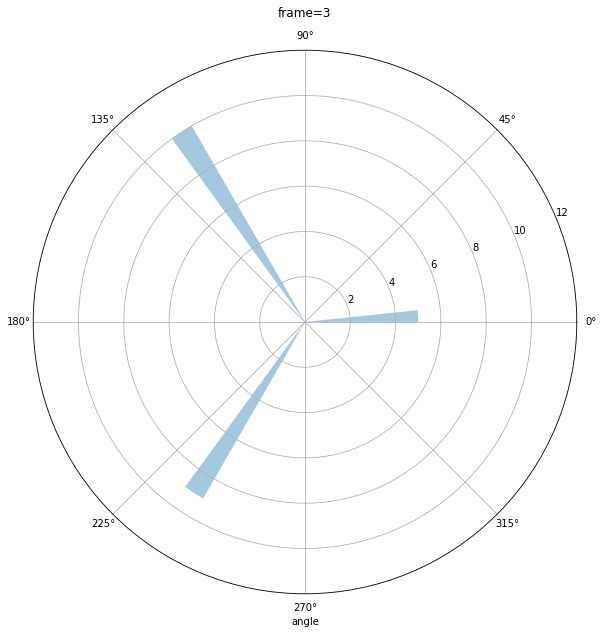

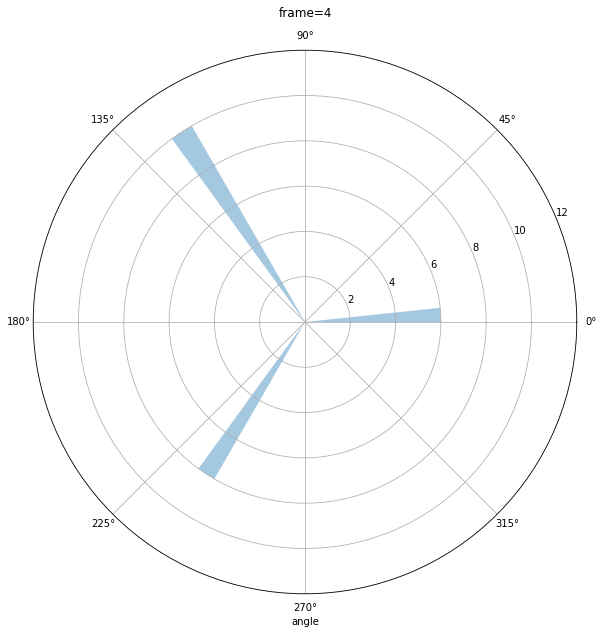

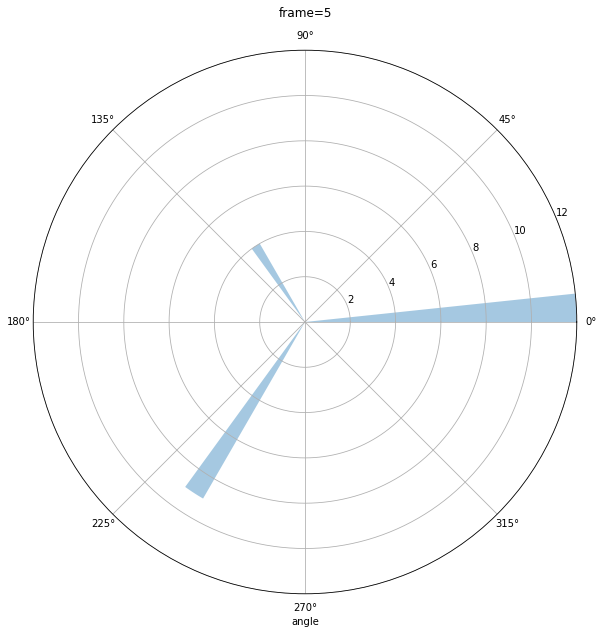

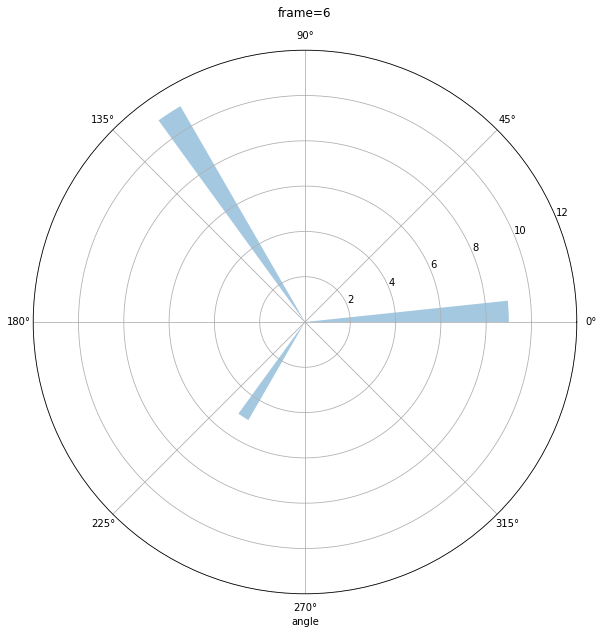

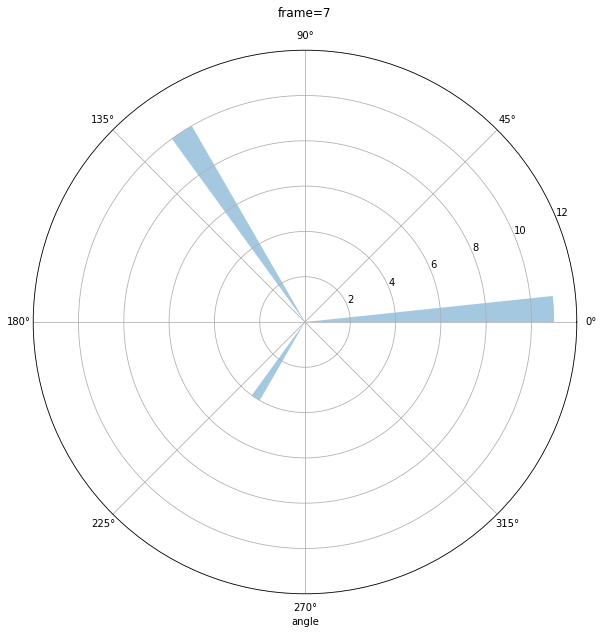

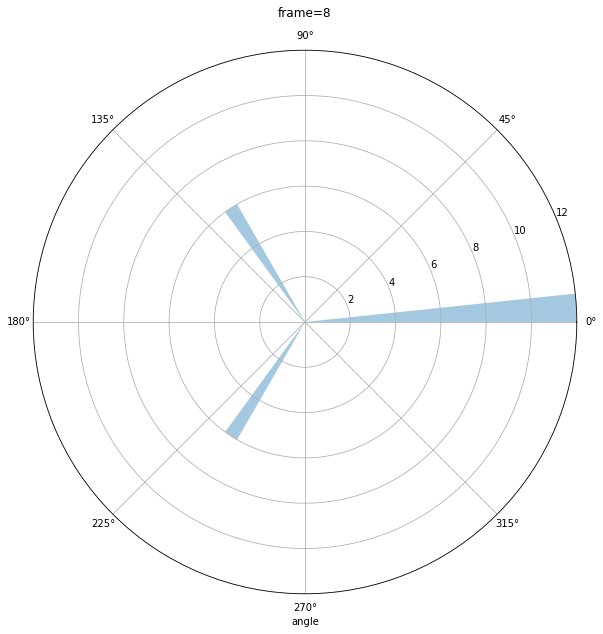

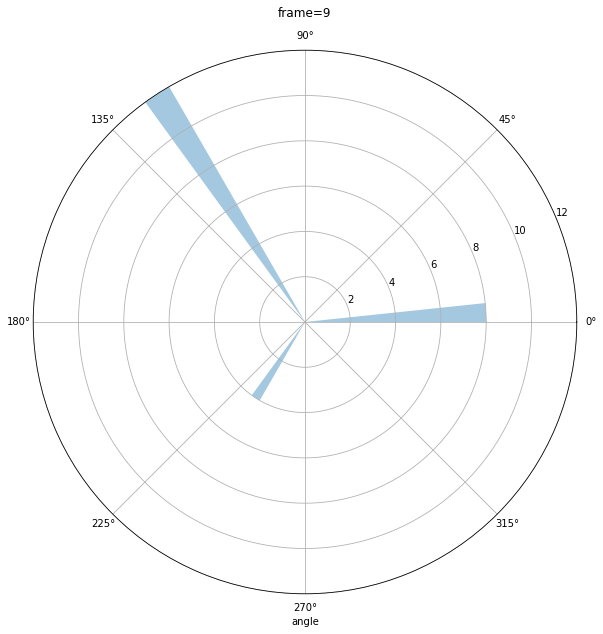

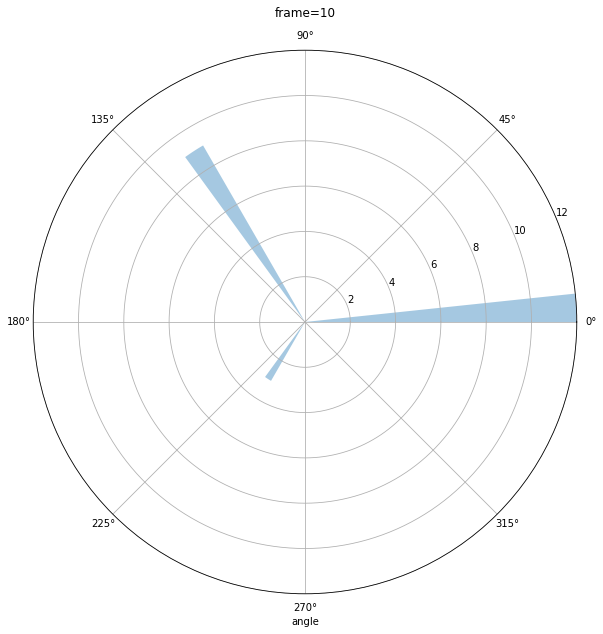

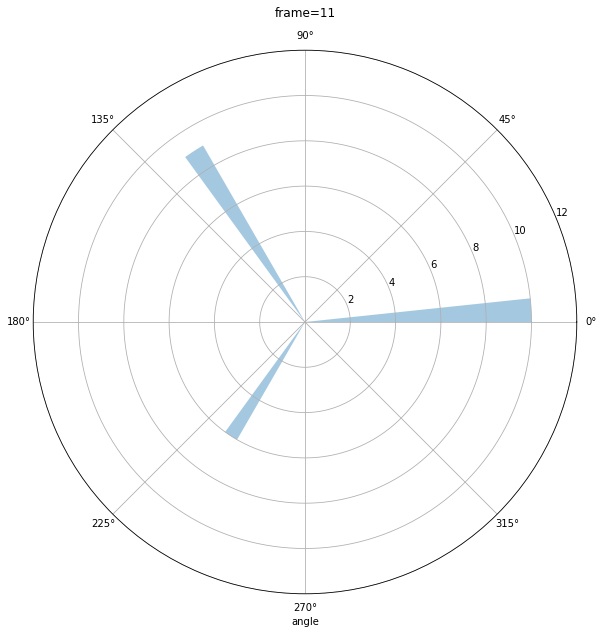

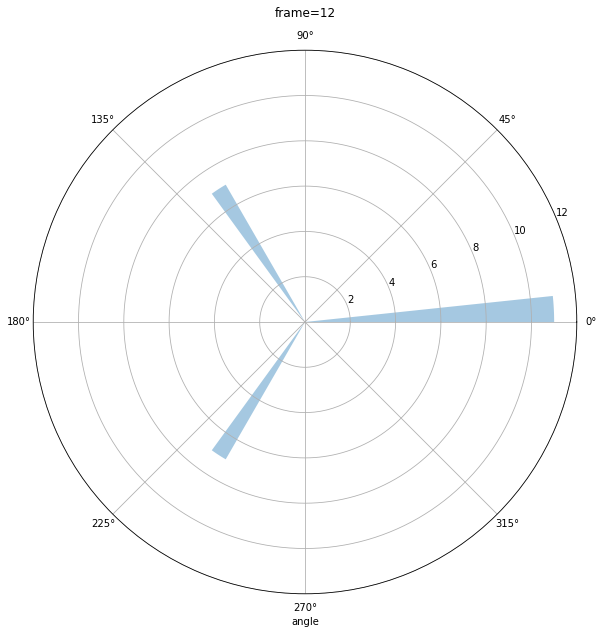

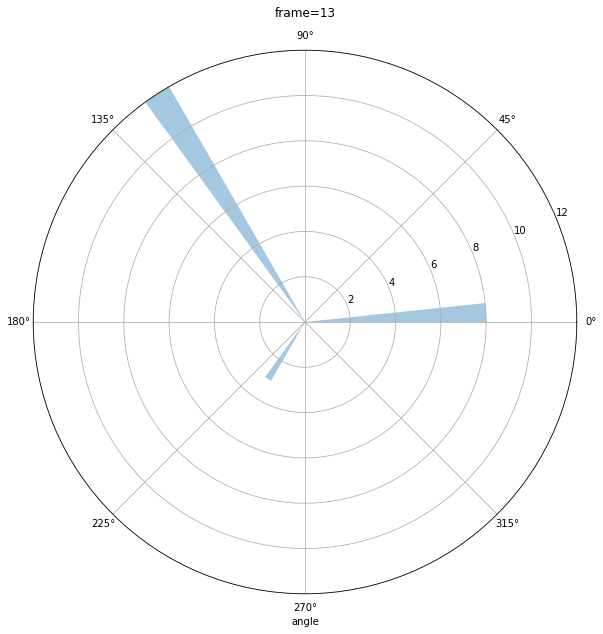

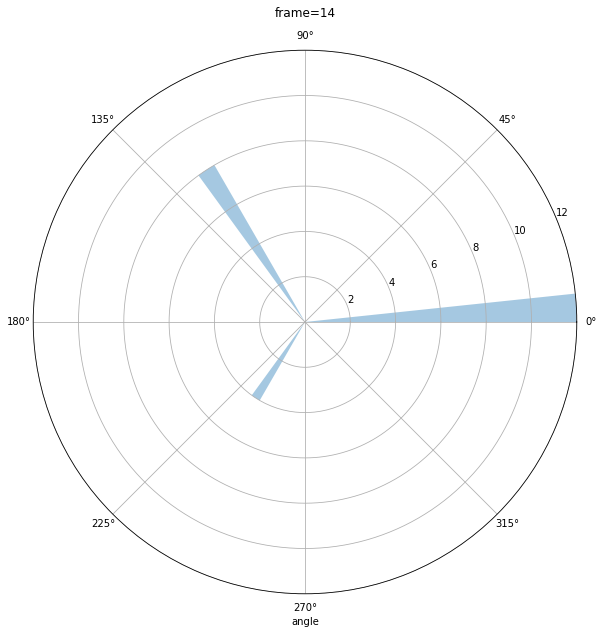

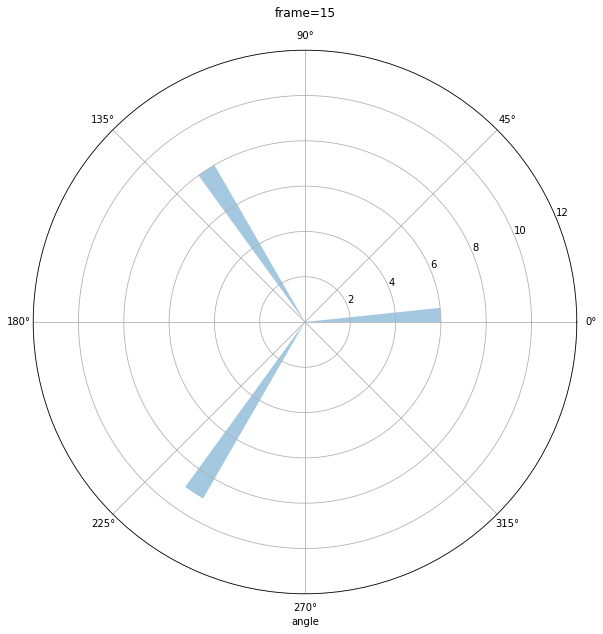

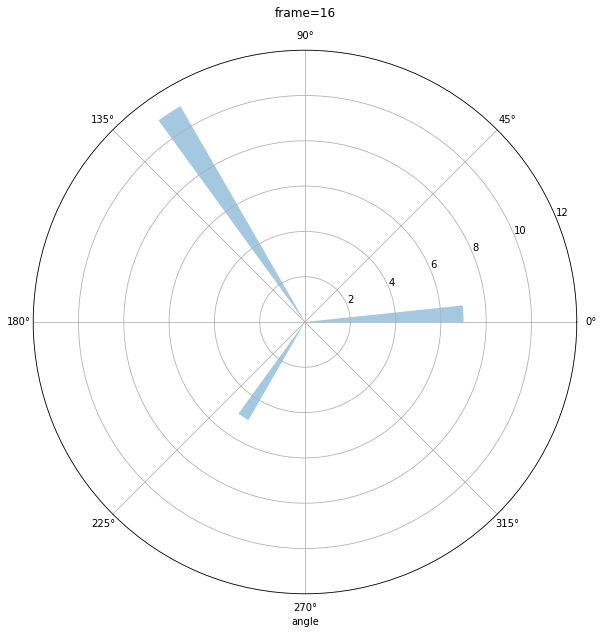

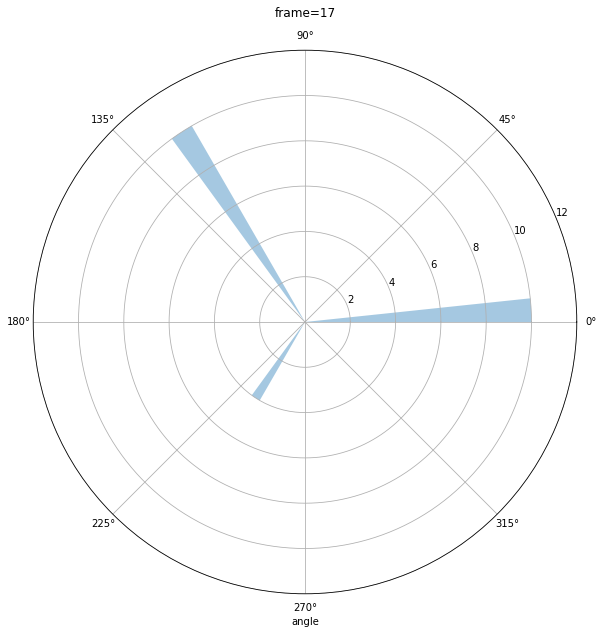

In [213]:
fns=[]
for i in range(len(frames)):
    fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
    ax.set_rlim(0,12)
    title = 'frame={}'.format(i)
    ax.set_title(title)
    sns.distplot(f[f.frame==i].angle, kde=False, bins=40)
    fn = 'test_orientations/test_orientation_distribution/{0:03}.png'.format(i)
    fns.append(fn)
    fig.savefig(fn)
images = []
singlemoviefolder = 'test_orientations/test_orientation_distribution/'
moviename = 'orientation_distributions'
for fn in fns:
    images.append(imageio.imread(fn))
    imageio.mimsave(singlemoviefolder + moviename + '.gif', images, duration=0.5)
# plt.axvline(10)

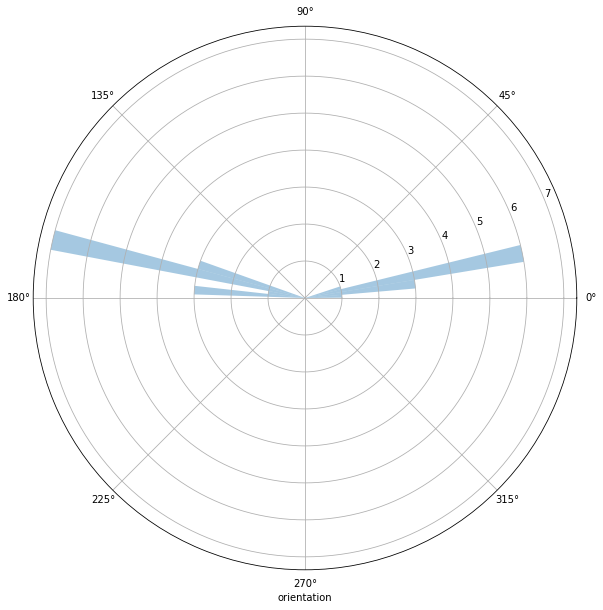

In [34]:
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw={'projection': 'polar'})
sns.distplot(f.orientation + np.pi/2, kde=False, bins=40)
# plt.axvline(10)

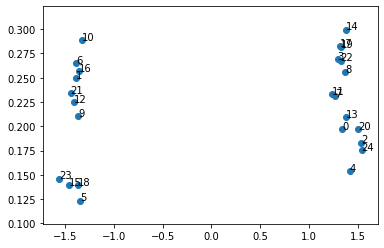

In [91]:
fig, ax = plt.subplots()
plt.scatter(f.orientation,f.ecc)
for i, txt in enumerate(f.index):
    ax.annotate(i, (f.orientation[i], f.ecc[i]))


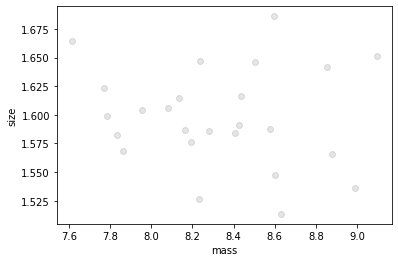

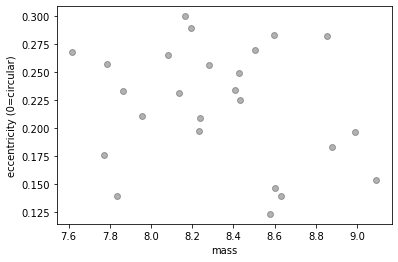

AttributeError: module 'trackpy' has no attribute 'mass_orientation'

In [75]:
t = tp.link(f, search_range=searchRange, adaptive_stop=10, memory=3)
plt.figure()
tp.mass_size(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass
tp.mass_ecc(t.groupby('particle').mean()); # convenience function -- just plots size vs. mass

In [188]:
t1 = t[((t['mass'] > min_mass) & (t['size'] > min_size) &
         (t['ecc'] < max_ecc)) & (t['mass'] < max_mass)]
t2 = tp.filter_stubs(t, 1)
# Compare the number of particles in the unfiltered and filtered data.
print('Before:', t['particle'].nunique())
print('After:', t2['particle'].nunique())

Before: 33
After: 33


In [189]:
t['diff_x'] = t.groupby('particle')['x'].diff().fillna(0)
t['diff_y'] = t.groupby('particle')['y'].diff().fillna(0)
t['alignment'] = pd.cut(t.orientation + np.pi/2, 3, labels=['90', '210', '330'])
t['last_align'] = t.groupby('particle')['alignment'].shift()
t[t.particle == 0].head()

,y,x,mass,size,ecc,orientation,angle,signal,raw_mass,ep,frame,particle,diff_x,diff_y,alignment,last_align
0,12.679963,62.506626,16.615752,2.597628,0.155055,1.013297,4.188790,0.549425,17.005332,0.044375,0,0,0.000000,0.000000,330,NaN
10,52.879901,82.331820,15.874484,2.484205,0.076273,-1.169756,2.094395,0.556884,26.201987,0.030585,1,0,19.825194,40.199938,90,330
18,49.692837,63.334993,15.640352,2.505187,0.047653,-0.201292,0.000000,0.554411,23.914365,0.031094,2,0,-18.996827,-3.187064,210,90
28,16.863767,69.373560,15.162521,2.463209,0.072959,-1.185352,2.094395,0.556803,15.667359,0.043902,3,0,6.038566,-32.829070,90,210
39,27.637764,63.221715,15.200855,2.470168,0.059511,-0.626753,2.094395,0.563637,18.751427,0.045543,4,0,-6.151845,10.773997,90,90


In [190]:
t.groupby('alignment').size()

alignment
90     39
210    27
330    45
dtype: int64

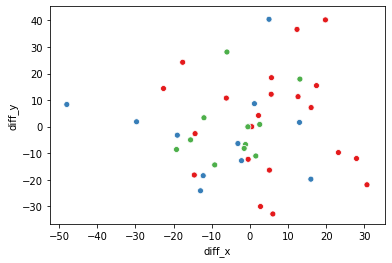

In [191]:
ax = plt.axes()
for p in t.particle.unique():
    tmp = t[t.particle == p]
    sns.scatterplot(data=tmp.iloc[1:], x='diff_x', y='diff_y', hue=tmp.iloc[:-1].alignment, palette=sns.color_palette("Set1", 3), ax=ax)
ax.get_legend().remove()

0.2814919532051806 203
3.6224735390829985 3
0.27438665800593987 137


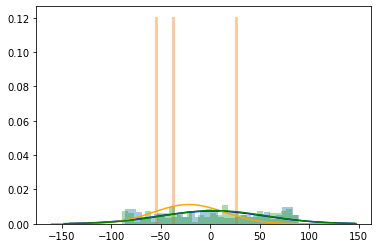

In [11]:
from scipy.stats import norm
ax = plt.axes()
colors = ("blue", "orange", "green")
for i, alignment in enumerate(['90', '210', '330']):
    sns.distplot(np.arctan(t[t.last_align == alignment]['diff_y'] / t[t.last_align == alignment]['diff_x']) * 180 / np.pi, fit=norm, fit_kws={"color":colors[i]}, kde=False, bins=30)
    print(np.mean(t[t.last_align == alignment]['diff_x']), len(t[t.last_align == alignment]))

-0.312983047708664 203
-1.3678455550319129 3
-0.45491842530678034 137


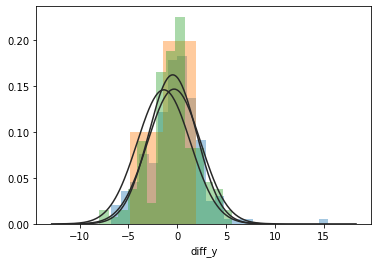

In [12]:
ax = plt.axes()
for alignment in ['90', '210', '330']:
    sns.distplot(t[t.last_align == alignment]['diff_y'], fit=norm, kde=False, norm_hist=False)
    print(np.mean(t[t.last_align == alignment]['diff_y']), len(t[t.last_align == alignment]))

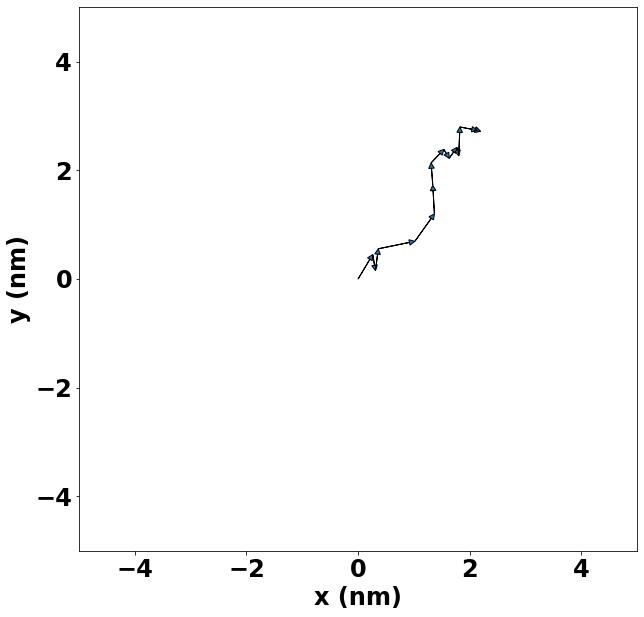

In [13]:
from scipy.stats import norm
NM_PER_PIXEL = frames.meters_per_pixel*1e9
d = tp.compute_drift(t2)

mpl.rcParams.update({'font.size': 24, 'font.weight':'bold'})
plt.figure(figsize=(10, 10))
#colors = ['r', 'k', 'b', 'g', 'tab:orange', 'tab:purple', 'm']
cmap = plt.cm.get_cmap("magma")

d.loc[0] = [0, 0]
arrs = []
j = 0
d['y'] = d['y']*-1
#     sns.scatterplot(x='x', y='y', data=d * NM_PER_PIXEL, alpha=0.0)
for i in range(1, len(d)):
    d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
    plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
    shape='full', length_includes_head=True, 
    zorder=0, head_length=0.1, head_width=0.1,linewidth=1)
else:
    d0, d1 = d.loc[i - 1] * NM_PER_PIXEL, d.loc[i] * NM_PER_PIXEL
    arrs.append(plt.arrow(d0.x,d0.y,d1.x-d0.x, d1.y-d0.y, 
    shape='full', length_includes_head=True, 
    zorder=0, head_length=0.1, head_width=0.1,))
#plt.title("Ensemble Drift, " + SXM_PATH[0][0] + " to {}".format(SXM_PATH[-1][-1]))
plt.xlabel("x (nm)",fontsize=24,fontweight='bold')
plt.ylabel("y (nm)",fontsize=24,fontweight='bold')
plt.xlim(-5, 5)
plt.ylim(-5, 5)
plt.show()